In [14]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np 


from aind_behavior_gym.dynamic_foraging.task import (CoupledBlockTask,
                                                     RandomWalkTask,
                                                     UncoupledBlockTask)
from aind_dynamic_foraging_models import generative_model
from aind_dynamic_foraging_models.generative_model import ForagerCollection
from aind_dynamic_foraging_models.generative_model.params import ParamsSymbols
from aind_dynamic_foraging_models.generative_model.params.util import get_params_options
from aind_dynamic_foraging_basic_analysis import compute_foraging_efficiency


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
forager_collection = ForagerCollection()
df = forager_collection.get_all_foragers()
df.columns

Index(['agent_class_name', 'agent_kwargs', 'agent_alias',
       'number_of_learning_rate', 'number_of_forget_rate', 'choice_kernel',
       'action_selection', 'preset_name', 'n_free_params', 'params', 'forager',
       'win_stay_lose_switch'],
      dtype='object')

In [16]:
df[['agent_class_name', 'preset_name', 'n_free_params', 'params']]

,agent_class_name,preset_name,n_free_params,params
0,ForagerQLearning,None,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
1,ForagerQLearning,Rescorla-Wagner,3,"ParamsSymbols.learn_rate, ParamsSymbols.biasL,..."
2,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
3,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
4,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
5,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.choice..."
6,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
7,ForagerQLearning,None,4,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
8,ForagerQLearning,Bari2019,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."
9,ForagerQLearning,None,5,"ParamsSymbols.learn_rate, ParamsSymbols.forget..."


In [17]:
# Initialize agent

forager = ForagerCollection().get_preset_forager('Hattori2019', seed=42)
forager.set_params(
    softmax_inverse_temperature=5,
    biasL=0
)

# Create task environment

task = CoupledBlockTask(reward_baiting=True, num_trials=1000, seed=42)

Foraging efficiency: 0.8222 (random seed: 0.7727272727272727)


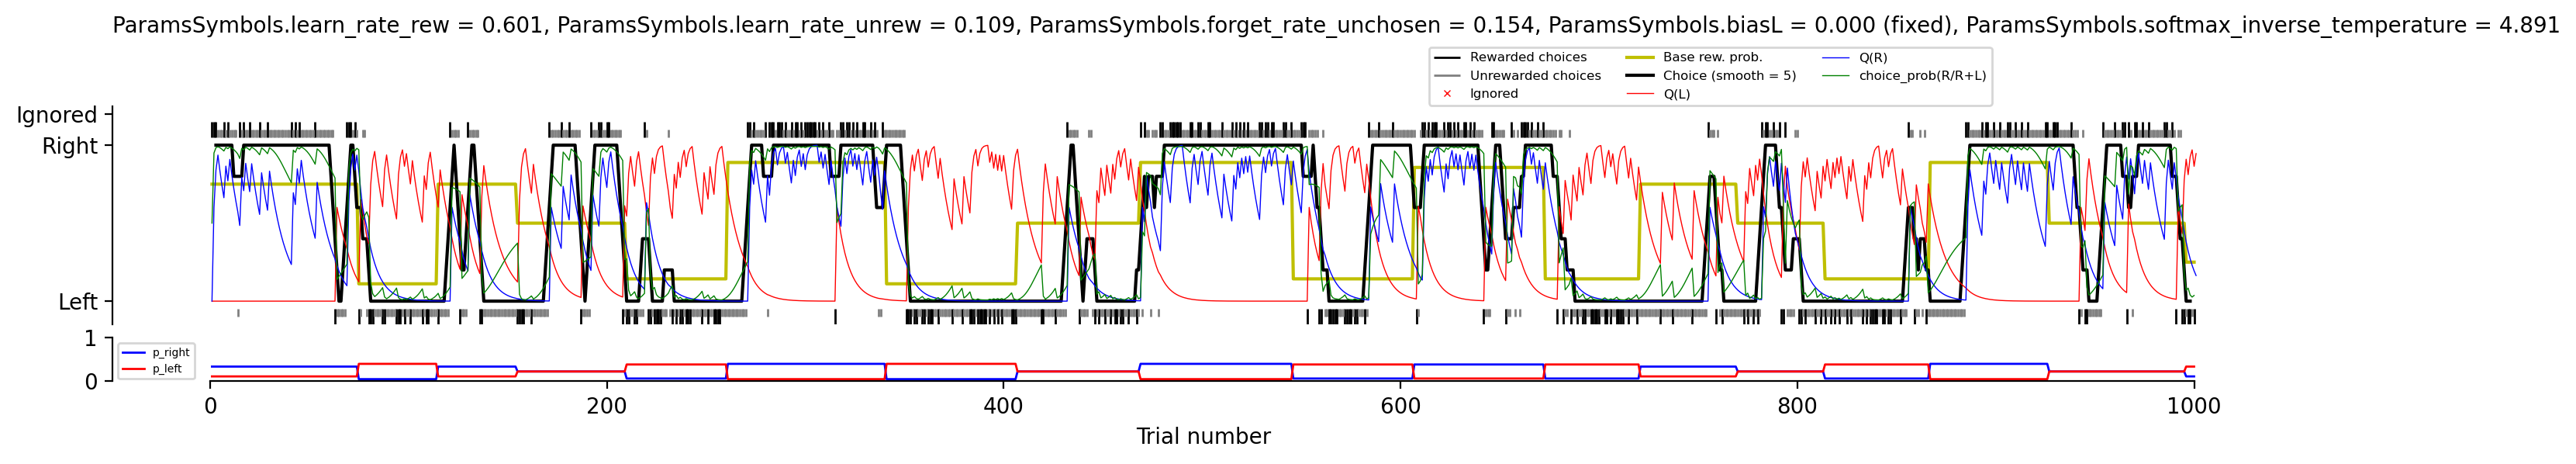

In [23]:
# Run the model
forager.perform(task)

# Get results
ground_truth_params = forager.params.model_dump()
ground_truth_choice_prob = forager.choice_prob
ground_truth_q_value = forager.q_value

# Evaluate the foraging efficiency
foraging_eff, foraging_eff_random_seed = compute_foraging_efficiency(
    baited=task.reward_baiting,
    choice_history=forager.get_choice_history(),
    reward_history=forager.get_reward_history(),
    p_reward=forager.get_p_reward(),
    random_number=task.random_numbers.T,
)

print(f"Foraging efficiency: {foraging_eff:.4f} (random seed: {foraging_eff_random_seed})")

# Get history
choice_history = forager.get_choice_history()
reward_history = forager.get_reward_history()

# Plot session
fig, axes = forager.plot_session(if_plot_latent=True)

In [19]:
# Parameter recovery 

# Fit model to recover parameters

forager.fit(
    choice_history,
    reward_history,
    fit_bounds_override = {'softmax_inverse_temperature': [0, 100]},
    clamp_params = {'biasL': 0},
    DE_kwargs = dict(workers=4, disp=True, seed=np.random.default_rng(42)),
    k_fold_cross_validation = None,
)

fitting_results = forager.fitting_result

2024-12-11 07:16:31,153 - aind_dynamic_foraging_models.generative_model.base - INFO - Fitting the model using the whole dataset...


differential_evolution step 1: f(x)= 289.0829807952948
differential_evolution step 2: f(x)= 278.66081064312925
differential_evolution step 3: f(x)= 271.07233761947083
differential_evolution step 4: f(x)= 271.07233761947083
differential_evolution step 5: f(x)= 271.07233761947083
differential_evolution step 6: f(x)= 267.7258166159626
differential_evolution step 7: f(x)= 267.7258166159626
differential_evolution step 8: f(x)= 267.7258166159626
differential_evolution step 9: f(x)= 261.55107374493673
differential_evolution step 10: f(x)= 261.1578133089714
differential_evolution step 11: f(x)= 261.1578133089714
differential_evolution step 12: f(x)= 259.92281388759886
differential_evolution step 13: f(x)= 258.0116776498438
differential_evolution step 14: f(x)= 258.0116776498438
differential_evolution step 15: f(x)= 258.0116776498438
differential_evolution step 16: f(x)= 258.0116776498438
differential_evolution step 17: f(x)= 258.0116776498438
differential_evolution step 18: f(x)= 258.011677649

In [20]:
# Check fitted parameters 
fit_names = fitting_results.fit_settings['fit_names']
ground_truth = [num for name, num in ground_truth_params.items() if name in fit_names]
print(f'Num of trials: {len(choice_history)}')
print(f'Fitted parameters: {fit_names}')
print(f'Ground truth: {[f"{num:.4f}" for num in ground_truth]}')
print(f'Fitted:       {[f"{num:.4f}" for num in fitting_results.x]}')
print(f"Likelihood-Per-Trial: {fitting_results.LPT}")
print(f"Prediction accuracy full dataset: {fitting_results.prediction_accuracy}\n")

Num of trials: 1000
Fitted parameters: ['learn_rate_rew', 'learn_rate_unrew', 'forget_rate_unchosen', 'softmax_inverse_temperature']
Ground truth: ['0.5000', '0.1000', '0.2000', '5.0000']
Fitted:       ['0.6011', '0.1087', '0.1544', '4.8908']
Likelihood-Per-Trial: 0.7732456884626638
Prediction accuracy full dataset: 0.902



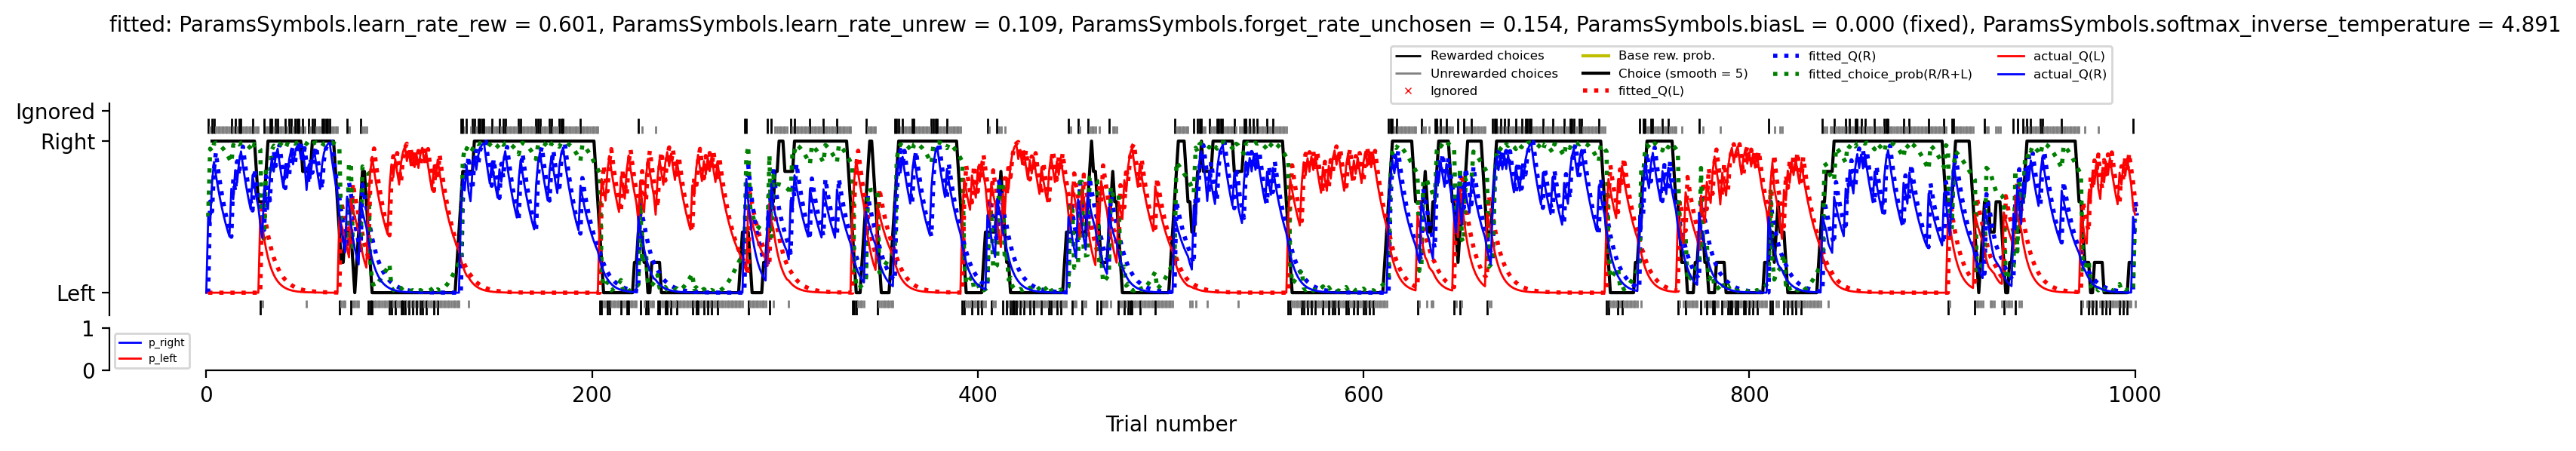

In [21]:
# Plot fitted session results

fig_fitting, axes = forager.plot_fitted_session(if_plot_latent=True)

# Overlay ground truth Q values
axes[0].plot(ground_truth_q_value[0], lw=1, color="red", ls="-", label="actual_Q(L)")
axes[0].plot(ground_truth_q_value[1], lw=1, color="blue", ls="-", label="actual_Q(R)")
axes[0].legend(fontsize=6, loc="upper left", bbox_to_anchor=(0.6, 1.3), ncol=4)